In [189]:
import pandas as pd
import numpy as np

from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.manifold import TSNE
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score
import xgboost as xgb

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import  pyLDAvis.sklearn

from tqdm import tqdm
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.lang.en import English
import string

import matplotlib.pyplot as plt


# !python3 -m spacy download en_core_web_lg --user

In [125]:
nlp = spacy.load('en_core_web_lg')

In [126]:
data = pd.read_csv("./winemag-data_first150k.csv")

In [127]:
data.isna().sum()

Unnamed: 0         0
country            5
description        0
designation    45735
points             0
price          13695
province           5
region_1       25060
region_2       89977
variety            0
winery             0
dtype: int64

In [128]:
# We can see duplicated rows
data.loc[data["country"].isna()]

,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,variety,winery
1133,1133,NaN,Delicate white flowers and a spin of lemon pee...,Askitikos,90,17.0,NaN,NaN,NaN,Assyrtiko,Tsililis
1440,1440,NaN,"A blend of 60% Syrah, 30% Cabernet Sauvignon a...",Shah,90,30.0,NaN,NaN,NaN,Red Blend,Büyülübağ
68226,68226,NaN,"From first sniff to last, the nose never makes...",Piedra Feliz,81,15.0,NaN,NaN,NaN,Pinot Noir,Chilcas
113016,113016,NaN,"From first sniff to last, the nose never makes...",Piedra Feliz,81,15.0,NaN,NaN,NaN,Pinot Noir,Chilcas
135696,135696,NaN,"From first sniff to last, the nose never makes...",Piedra Feliz,81,15.0,NaN,NaN,NaN,Pinot Noir,Chilcas


In [129]:
# Remove duplicate and NA
data = data[data.duplicated('description', keep=False)]
data = data.dropna(subset=['description', 'points', 'country', 'province', 'price'])

Length of dataframe after duplicates are removed: 92393
Length of dataframe after NaNs are removed: 83945


In [130]:
data.isna().sum()

Unnamed: 0         0
country            0
description        0
designation    25735
points             0
price              0
province           0
region_1       14453
region_2       46677
variety            0
winery             0
dtype: int64

In [131]:
# Remove variables, the Unnamed variable is just an index, the region_2 is mostly empty
data = data.drop(['Unnamed: 0', 'region_2'], axis=1)

In [132]:
# Fill NA
data = data.fillna(value={'designation': "EMPTY", 'region_1': "EMPTY"})

In [133]:
labels = data['points']


descriptions = data['description']

In [134]:
punctuations = string.punctuation
stopwords = list(STOP_WORDS)

In [135]:
# Parser for reviews
parser = English()
def spacy_tokenizer(sentence):
    mytokens = parser(sentence)
    mytokens = [ word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in mytokens ]
    mytokens = [ word for word in mytokens if word not in stopwords and word not in punctuations ]
    mytokens = " ".join([i for i in mytokens])
    return mytokens

In [136]:
tqdm.pandas()
data["processed_description"] = data["description"].progress_apply(spacy_tokenizer)

100%|██████████| 83945/83945 [01:47<00:00, 781.64it/s]


In [137]:
vectorizer = CountVectorizer(lowercase=True)
data_vectorized = vectorizer.fit_transform(data["processed_description"])

In [138]:
lda = LatentDirichletAllocation(n_components=10, doc_topic_prior=.01, max_iter=10, learning_method='online',verbose=True)
data_lda = lda.fit_transform(data_vectorized)

iteration: 1 of max_iter: 10
iteration: 2 of max_iter: 10
iteration: 3 of max_iter: 10
iteration: 4 of max_iter: 10
iteration: 5 of max_iter: 10
iteration: 6 of max_iter: 10
iteration: 7 of max_iter: 10
iteration: 8 of max_iter: 10
iteration: 9 of max_iter: 10
iteration: 10 of max_iter: 10


In [139]:
pyLDAvis.enable_notebook()
dash = pyLDAvis.sklearn.prepare(lda, data_vectorized, vectorizer, mds='tsne')
dash

/home/prdx/.local/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=                x           y  topics  cluster       Freq
topic                                                    
6      -48.290363   12.957685       1        1  24.070773
8       76.317268   77.724243       2        1  15.098667
0        9.804424   50.920185       3        1  13.763161
5       36.761948  -84.863411       4        1  12.160422
7      -80.225800   79.386024       5        1   8.579279
1       13.570970  -18.376568       6        1   7.669014
4       -8.269468  120.327164       7        1   5.550577
9     -115.518295   -8.019401       8        1   5.390647
3      -50.074886  -67.555595       9        1   4.404566
2       86.004913   -4.526914      10        1   3.312895, topic_info=      Category          Freq        Term         Total  loglift  logprob
term                                                                    
4945   Default  18563.000000         dry  18563.000000  30.0000  30.0000
14212  Default  13390.000000        spin  13390.000000  29.0000  29.0000
1149   Default  18213.000000       aroma  18213.000000  28.0000  28.0000
10908  Default  15553.000000      palate  15553.000000  27.0000  27.0000
2493   Default   6483.000000    cabernet   6483.000000  26.0000  26.0000
16851  Default  51767.000000        wine  51767.000000  25.0000  25.0000
3089   Default  23681.000000      cherry  23681.000000  24.0000  24.0000
6022   Default  49484.000000      flavor  49484.000000  23.0000  23.0000
1850   Default  11333.000000  blackberry  11333.000000  22.0000  22.0000
3270   Default   7060.000000      citrus   7060.000000  21.0000  21.0000
1847   Default  13609.000000       black  13609.000000  20.0000  20.0000
1038   Default   7573.000000       apple   7573.000000  19.0000  19.0000
1896   Default   8367.000000       blend   8367.000000  18.0000  18.0000
15036  Default  17344.000000      tannin  17344.000000  17.0000  17.0000
14891  Default  13346.000000       sweet  13346.000000  16.0000  16.0000
16467  Default   4183.000000    vineyard   4183.000000  15.0000  15.0000
5936   Default  24084.000000      finish  24084.000000  14.0000  14.0000
14199  Default  15567.000000       spice  15567.000000  13.0000  13.0000
503    Default  15564.000000     acidity  15564.000000  12.0000  12.0000
10468  Default  12335.000000         oak  12335.000000  11.0000  11.0000
1760   Default  12148.000000       berry  12148.000000  10.0000  10.0000
9531   Default   4167.000000      merlot   4167.000000   9.0000   9.0000
10376  Default   9460.000000        nose   9460.000000   8.0000   8.0000
16996  Default   9087.000000        year   9087.000000   7.0000   7.0000
6331   Default   9426.000000       fresh   9426.000000   6.0000   6.0000
4474   Default   3292.000000   delicious   3292.000000   5.0000   5.0000
6380   Default  39647.000000       fruit  39647.000000   4.0000   4.0000
13235  Default   4851.000000   sauvignon   4851.000000   3.0000   3.0000
11430  Default   5620.000000       pinot   5620.000000   2.0000   2.0000
4091   Default   8220.000000       crisp   8220.000000   1.0000   1.0000
...        ...           ...         ...           ...      ...      ...
6966   Topic10    890.751384    grenache    891.637337   3.4064  -4.3037
17082  Topic10    877.595735   zinfandel    878.481724   3.4063  -4.3186
12553  Topic10    738.049941    residual    738.935895   3.4061  -4.4918
11288  Topic10    671.748393      petite    672.634317   3.4060  -4.5859
2305   Topic10    635.207972       brown    636.093953   3.4060  -4.6418
13831  Topic10    630.557809       sirah    631.443721   3.4059  -4.6492
5755   Topic10    615.562564         fat    616.448627   3.4059  -4.6732
289    Topic10    590.300685          50    591.186679   3.4058  -4.7151
1520   Topic10    539.868200     barbera    540.754248   3.4057  -4.8045
7968   Topic10    539.037650       italy    539.923705   3.4057  -4.8060
16945  Topic10    488.274711       worth    489.160763   3.4055  -4.9049
11523  Topic10    451.469668    pleasure    452.3

(array([ 585., 2599., 5445., 7542., 4487., 3174., 1420.,  373.,   87.,
          23.]),
 array([ 80.,  82.,  84.,  86.,  88.,  90.,  92.,  94.,  96.,  98., 100.]),
 <a list of 10 Patch objects>)

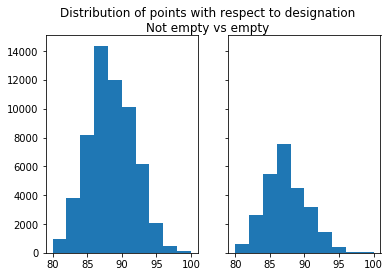

In [204]:
designation_not_empty = data[data['designation'] != "EMPTY"]
designation_empty =  data[data['designation'] == "EMPTY"]

fig, axs = plt.subplots(1, 2, sharey=True)
fig.suptitle("Distribution of points with respect to designation\nNot empty vs empty")
axs[0].hist(designation_not_empty['points'])
axs[1].hist(designation_empty['points'])

In [202]:
df = data

# We drop description because we don't need it anymore
# We drop points as it is the targetted variable and has been moved to labels
# We drop province and use country instead
# We drop designation as it has many missing values, and the distribution of the missing value is the same with the non missing value
df = df.drop(['description', 'province', 'points', 'designation'], axis=1)

In [203]:
# Transform to one-hot-vector
categorical_columns = ['country', 'region_1', 'variety', 'winery']
X = pd.get_dummies(df, columns=categorical_columns, sparse=True)

In [142]:
X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.2, random_state=42)

In [145]:
vectorizer = CountVectorizer(lowercase=True)
data_vectorized_train = vectorizer.fit_transform(X_train["processed_description"])
data_vectorized_test = vectorizer.transform(X_test["processed_description"])

In [146]:
lda = LatentDirichletAllocation(n_components=10, doc_topic_prior=.01, max_iter=10, learning_method='online',verbose=True)
data_lda_train = lda.fit_transform(data_vectorized_train)
data_lda_test = lda.transform(data_vectorized_test)

iteration: 1 of max_iter: 10
iteration: 2 of max_iter: 10
iteration: 3 of max_iter: 10
iteration: 4 of max_iter: 10
iteration: 5 of max_iter: 10
iteration: 6 of max_iter: 10
iteration: 7 of max_iter: 10
iteration: 8 of max_iter: 10
iteration: 9 of max_iter: 10
iteration: 10 of max_iter: 10


In [155]:
# Append LDA result to the dataframe
for i, d_train in enumerate(data_lda_train.T):
    X_train['topic_' + str(i)] = d_train

In [159]:
# Append LDA result to the dataframe
for i, d_test in enumerate(data_lda_test.T):
    X_test['topic_' + str(i)] = d_test

In [175]:
# Normalized price
scaler = StandardScaler()
X_train['price'] = scaler.fit_transform(np.array(X_train['price']).reshape(-1, 1))
X_test['price'] = scaler.transform(np.array(X_test['price']).reshape(-1, 1))

In [181]:
# Just a quick check with a model
test = RandomForestRegressor(max_depth=100)
test.fit(X_train, y_train)
test.score(X_test, y_test)

/home/prdx/.local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0.892041706473874

---------------------------------------------------------------------------------------------------

In [ ]:
parameters = {'max_depth': [None, 10, 100], 'n_estimators': [500, 700, 1000]}

rf_cv = GridSearchCV(RandomForestRegressor(), parameters, cv=10, scoring="r2", 
                   n_jobs=8, verbose=1)
rf_cv.fit(X_train, y_train)

---------------------------------------------------------------------------------

In [146]:
parameters = {'max_depth': [None, 10, 100], 'n_estimators': [500, 700, 1000]}

xgb_cv = GridSearchCV(xgb.XGBRegressor(), parameters, cv=10, scoring="r2", 
                   n_jobs=8, verbose=1)
xgb_cv.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=100, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

---------------------------------------------------------------------------------

In [165]:
parameters = {alpha=[1, 0.1, 0.01, 0.001]}
ridge_cv = GridSearchCV(Ridge(), parameters, cv=10, scoring="r2", 
                   n_jobs=8, verbose=1)
ridge_cv.fit(X_train, y_train)

Ridge(alpha=0.001, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

--------------------------------------------------------------------------------------------------

--------------------------------------------------------------------------------------------------------------------